### 3.Moving Average (MA), Exponentially Weighted MA and Garch Volatility Estimates
##### Edited by Xuyang Liu

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [2]:
# read the data
data = pd.read_excel('SPData.xlsx',index_col=0)
data = data.sort_values('Date')

##### Problem (a)

In [3]:
delta = 1/252
n = 100

# for MA
Xt = np.log(data['Closing Price']/data['Closing Price'].shift(1)).dropna()
MA = pd.Series(index=Xt.index[n:])
for i in range(len(MA)): 
    MA.iloc[i] = Xt.iloc[i: i+n].var()/delta


/var/folders/jp/bc6syfnn06nd5vh0zytf1ry80000gn/T/ipykernel_93233/3628919852.py:6: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  MA = pd.Series(index=Xt.index[n:])


In [4]:
Xt

Date
2015-08-04   -0.002252
2015-08-05    0.003110
2015-08-06   -0.007783
2015-08-07   -0.002879
2015-08-10    0.012727
                ...   
2021-08-24    0.001495
2021-08-25    0.002218
2021-08-26   -0.005842
2021-08-27    0.008769
2021-08-30    0.004297
Name: Closing Price, Length: 1530, dtype: float64

In [4]:
# For EWMA
def EWMA(lamda):
    a0 = Xt.iloc[0:100].var()
    Xtsq = Xt **2
    EWMA = pd.Series(index=Xt.index[n:])
    EWMA.iloc[0] = a0
    for i in range(len(EWMA)-1):
        EWMA.iloc[i+1] = EWMA.iloc[i] * lamda + (1-lamda) * (Xtsq.iloc[i+100])
        
    return EWMA/delta
        
EWMA94 = EWMA(0.94)
EWMA97 = EWMA(0.97)

/var/folders/jp/bc6syfnn06nd5vh0zytf1ry80000gn/T/ipykernel_22365/2694388682.py:5: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  EWMA = pd.Series(index=Xt.index[n:])


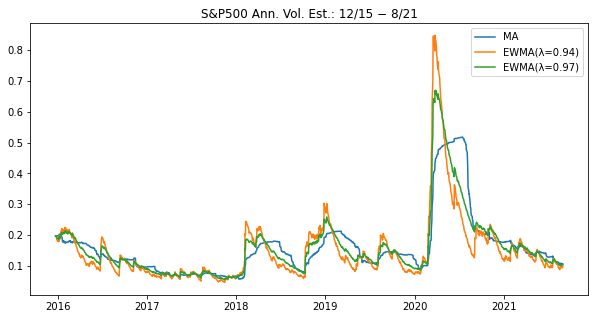

In [5]:
# plot the figure
plt.figure(figsize=(10,5))
plt.title('S&P500 Ann. Vol. Est.: 12/15 − 8/21')
plt.plot(MA**0.5, label='MA') # use standard deviation
plt.plot(EWMA94**0.5, label='EWMA(λ=0.94)')
plt.plot(EWMA97**0.5, label='EWMA(λ=0.97)')
plt.legend()
plt.show()

##### Problem(b)

In [6]:
from arch import arch_model

In [7]:
garch_Xt = Xt['2019-03-01':'2020-2-28']
model=arch_model(garch_Xt) 
garch=model.fit(update_freq=0)

Optimization terminated successfully    (Exit mode 0)
            Current function value: -876.2894471258735
            Iterations: 7
            Function evaluations: 30
            Gradient evaluations: 3


/Users/liuxuyang/opt/anaconda3/lib/python3.8/site-packages/arch/univariate/base.py:309: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 7.272e-05. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 100 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(


In [8]:
print(garch.summary())

                     Constant Mean - GARCH Model Results                      
Dep. Variable:          Closing Price   R-squared:                       0.000
Mean Model:             Constant Mean   Adj. R-squared:                  0.000
Vol Model:                      GARCH   Log-Likelihood:                876.289
Distribution:                  Normal   AIC:                          -1744.58
Method:            Maximum Likelihood   BIC:                          -1730.46
                                        No. Observations:                  252
Date:                Mon, Sep 12 2022   Df Residuals:                      251
Time:                        12:58:33   Df Model:                            1
                                 Mean Model                                 
                 coef    std err          t      P>|t|      95.0% Conf. Int.
----------------------------------------------------------------------------
mu         1.1528e-03  6.352e-06    181.485      0.000 [1.

In [9]:
alpha0 = garch.params.omega
alpha1 = garch.params.loc['alpha[1]']
beta1 = garch.params.loc['beta[1]']

tm_MA = MA['2020-3-1':'2020-4-30']
tm_EWMA94=EWMA94['2020-3-1':'2020-4-30']
tm_EWMA97=EWMA97['2020-3-1':'2020-4-30']

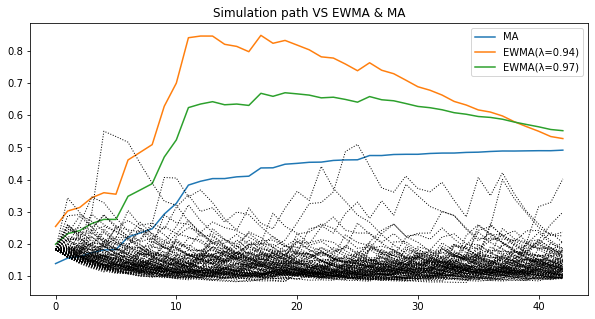

In [22]:
first_ret = Xt['2020-2-28']
first_vol = EWMA97['2020-2-28'] * delta # here i just set EWMA97 in 2/28/2020 as our first vol. 
                                        # EWMA has been annualized, so I just inverse the annualization, and I'll convert them back after simulation.

def sim_path(): 
    sim_x = [first_ret]
    sim_v = [first_vol]
    for i in range(43):
        vol = alpha0 + alpha1 * sim_x[-1]**2 + beta1 * sim_v[-1]
        x = (vol**0.5) * np.random.normal(0,1)
        sim_x += [x]
        sim_v += [vol]
    sim_v = sim_v[1:]

    
    return np.array(sim_v)/delta

# plot the figure
plt.figure(figsize=(10,5))
plt.title('Simulation path VS EWMA & MA')
plt.plot(tm_MA.values**0.5, label='MA') # use standard deviation
plt.plot(tm_EWMA94.values**0.5, label='EWMA(λ=0.94)')
plt.plot(tm_EWMA97.values**0.5, label='EWMA(λ=0.97)')
for i in range(100):
    pt = sim_path()
    plt.plot(pt**0.5,color='black',linewidth=1,linestyle=':')
plt.legend()
plt.show()      

From the plot we can see that the simulation paths is around the MA and EWMA but much smaller during 10~20, maybe at that time the covid-19 situaiton in US reach the peak , so there's abnormal volatility in US market.